In [5]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/heart_disease_dataset.xlsx'
heart_data = pd.read_excel(file_path)

# Data Preprocessing
# 1. Handle missing values (if any)
heart_data = heart_data.fillna(heart_data.median())

# 2. Separate features and target variable
X = heart_data.drop('target', axis=1)
y = heart_data['target']

# 3. Identify categorical and numerical columns
categorical_cols = [col for col in X.columns if X[col].dtype == 'object' or len(X[col].unique()) < 10]
numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64'] and col not in categorical_cols]

# 4. Preprocessing for numerical data: scaling
numerical_transformer = StandardScaler()

# 5. Preprocessing for categorical data: one-hot encoding
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

# 6. Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 7. Create a pipeline that combines preprocessing and SVM model
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=42))
])

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define hyperparameter grid for SVM
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'poly', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

# Hyperparameter tuning with GridSearchCV
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Predict on the test set with the best estimator
y_pred_svm = grid_search.best_estimator_.predict(X_test)



Best parameters: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}


Accuracy: 0.51
Precision: 0.5284552845528455
Recall: 0.6190476190476191
F1 Score: 0.5701754385964912
ROC AUC Score: 0.5375438596491228


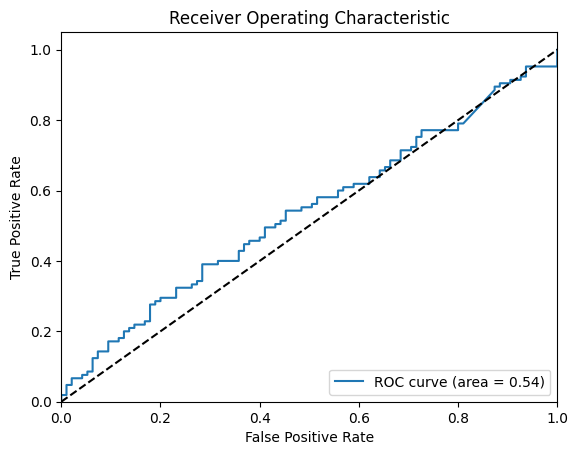

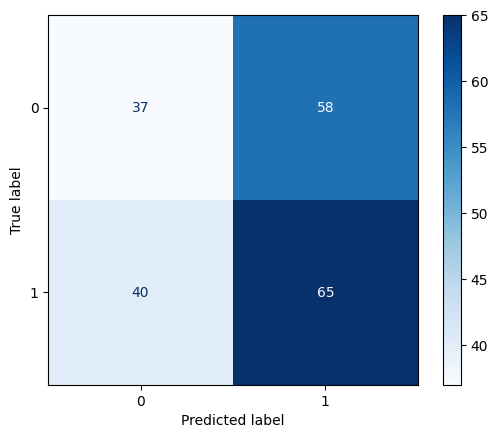

Confusion Matrix:
 [[37 58]
 [40 65]]


In [4]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on the test set
y_pred_svm = grid_search.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)
roc_auc = roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1])

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, grid_search.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Interpretation of Confusion Matrix
print("Confusion Matrix:\n", cm)

# Explanation of which metric is more appropriate
# If the problem involves misclassifying the minority class, recall or F1 score may be more important.
# In cases of medical diagnoses, for instance, we prefer a model with high recall to minimize false negatives.